In [267]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from scipy import signal, stats

In [268]:
filepath = os.path.join('data', 'crime_statistics', '001_13je_2022_20230715-104753.csv')
crimes_df = pd.read_csv(filepath)
crimes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 6 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   Year                                          161 non-null    int64 
 1   Country of permanent residence                161 non-null    object
 2   Nationality                                   161 non-null    object
 3   Offence group and specifier for criminal act  161 non-null    object
 4   Wellbeing services county                     161 non-null    object
 5   Persons suspected of solved offences          161 non-null    int64 
dtypes: int64(2), object(4)
memory usage: 7.7+ KB


In [269]:
path = os.path.join('data', 'migri_statistics', 'Decisions-First residence permit to Finland-012015-122022-en.csv')
first_permits_df = pd.read_csv(path, delimiter=';')

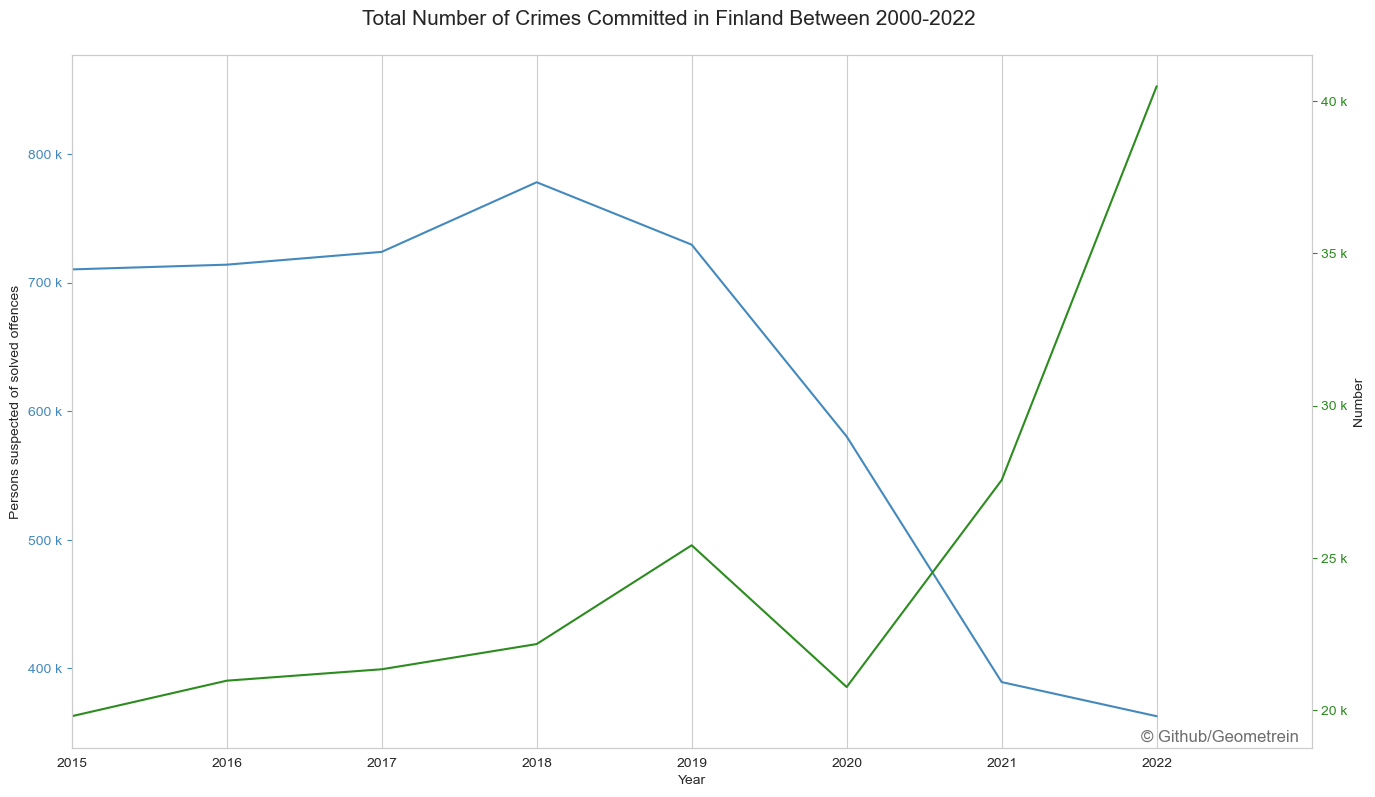

In [270]:
def plot_crime_rates_by_year(crimes_df: pd.DataFrame, permits_df: pd.DataFrame) -> tuple:
    # Data
    grouped_crimes = crimes_df.groupby(['Year'])['Persons suspected of solved offences'].sum().reset_index()
    permits_df = permits_df.loc[(permits_df['Decision'] == 'Positive') & (permits_df['Year'] < 2023)]
    grouped_permits = permits_df.groupby(['Year'])['Number'].sum().reset_index()
    grouped_permits.sort_values(by='Number', inplace=True, ascending=False)
    # Figure
    fig, ax1 = plt.subplots(figsize=(16, 9), facecolor='w')
    sns.lineplot(data=grouped_crimes, x="Year", y="Persons suspected of solved offences", color='#4489BD', ax=ax1)
    ax2 = plt.twinx()
    sns.lineplot(data=grouped_permits, x="Year", y="Number", color='#2c8c1f', ax=ax2)
    # Labels
    plt.suptitle(f"Total Number of Crimes Committed in Finland Between 2000-2022 ", y=0.93, fontsize=15)
    ax1.set(xlabel='Year', ylabel=f'Persons suspected of solved offences')
    ax1.set_xticks(range(2000, 2023, 1))
    ax1.set_xlim([2015, 2023])
    ax1.tick_params(axis='y', colors='#4489BD')
    ax2.tick_params(axis='y', colors='#2c8c1f')
    ax1.grid(axis='y')
    ax2.grid(False)
    ax1.yaxis.set_major_formatter(ticker.EngFormatter())
    ax2.yaxis.set_major_formatter(ticker.EngFormatter())
    # Author
    ax1.text(x=0.99, y=0.005, s='© Github/Geometrein', va='bottom', ha='right',
        transform=ax1.transAxes, color='#303030', fontsize=12, alpha=0.7
    )
    plt.show()
    return grouped_crimes, grouped_permits

yearly_crimes, yearly_permits = plot_crime_rates_by_year(crimes_df=crimes_df, permits_df=first_permits_df)

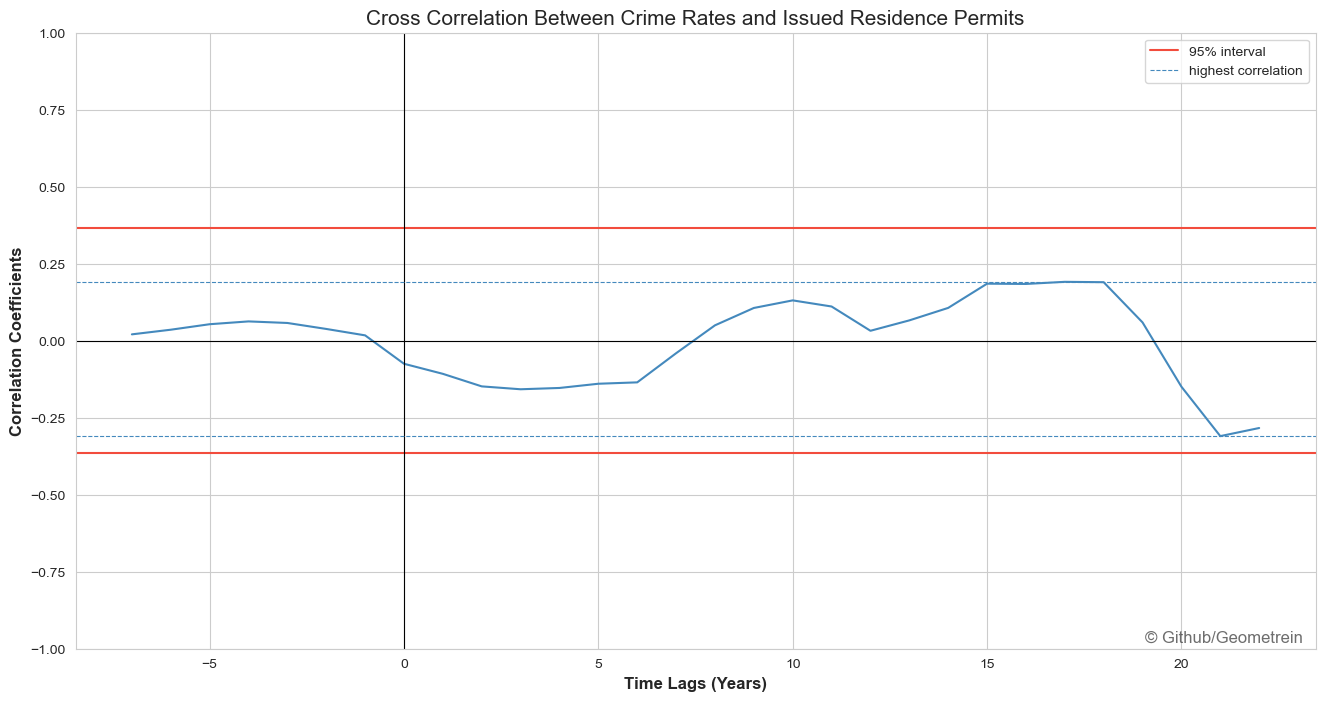

In [271]:
def get_cross_correlation_coefficients(series1: pd.Series, series2: pd.Series) -> np.ndarray:
    signal_1 = series1
    signal_2 = series2
    signal_1 = (signal_1 - np.mean(signal_1)) / (np.std(signal_1) * len(signal_1))
    target = (signal_2 - np.mean(signal_2)) / (np.std(signal_2))
    corr_coefficients = signal.correlate(signal_1, target, mode='full')
    return corr_coefficients


def get_p_vals(corr_coefficients: list[float]) -> list[float]:
    p_vals = []
    for r_coefficient in corr_coefficients:
        degrees_of_freedom = len(corr_coefficients) - 1
        t_statistic = r_coefficient * np.sqrt(degrees_of_freedom / 1 - r_coefficient**2)
        alpha = stats.t.sf(abs(t_statistic), df=degrees_of_freedom)
        p_vals.append(alpha)
    return p_vals


def ccf_plot(lags: np.ndarray, ccf: np.ndarray) -> None:
    fig, ax = plt.subplots(figsize=(16, 8))
    # Lagged Correlation
    ax.plot(lags, ccf, lw=1.5, color='#4489BD')
    # Confidence Intervals
    ax.axhline(y=-2/np.sqrt(len(lags)), color='#F24C3D', label='95% interval')
    ax.axhline(y=2/np.sqrt(len(lags)), color='#F24C3D')
    # Zero lag
    ax.axvline(x=0, color='black', lw=.8)
    ax.axhline(y=0, color='black', lw=.8)
    # Highest correlation
    ax.axhline(y=np.max(ccf), color='#4489BD', lw=.8, linestyle='--', label='highest correlation')
    ax.axhline(y=np.min(ccf), color='#4489BD', lw=.8, linestyle='--')
    ax.set(ylim = [-1, 1])
    ax.set_title('Cross Correlation Between Crime Rates and Issued Residence Permits',  fontsize=15)
    ax.set_ylabel('Correlation Coefficients', weight='bold', fontsize=12)
    ax.set_xlabel('Time Lags (Years)', weight='bold', fontsize=12)
    # Author
    ax.text(x=0.99, y=0.005, s='© Github/Geometrein', va='bottom', ha='right',
        transform=ax.transAxes, color='#303030', fontsize=12, alpha=0.7
    )
    plt.legend()


lags = signal.correlation_lags(len(yearly_crimes['Persons suspected of solved offences']), len(yearly_permits['Number']))
ccf = get_cross_correlation_coefficients(yearly_crimes['Persons suspected of solved offences'], yearly_permits['Number'])
ccf_plot(lags=lags, ccf=ccf)

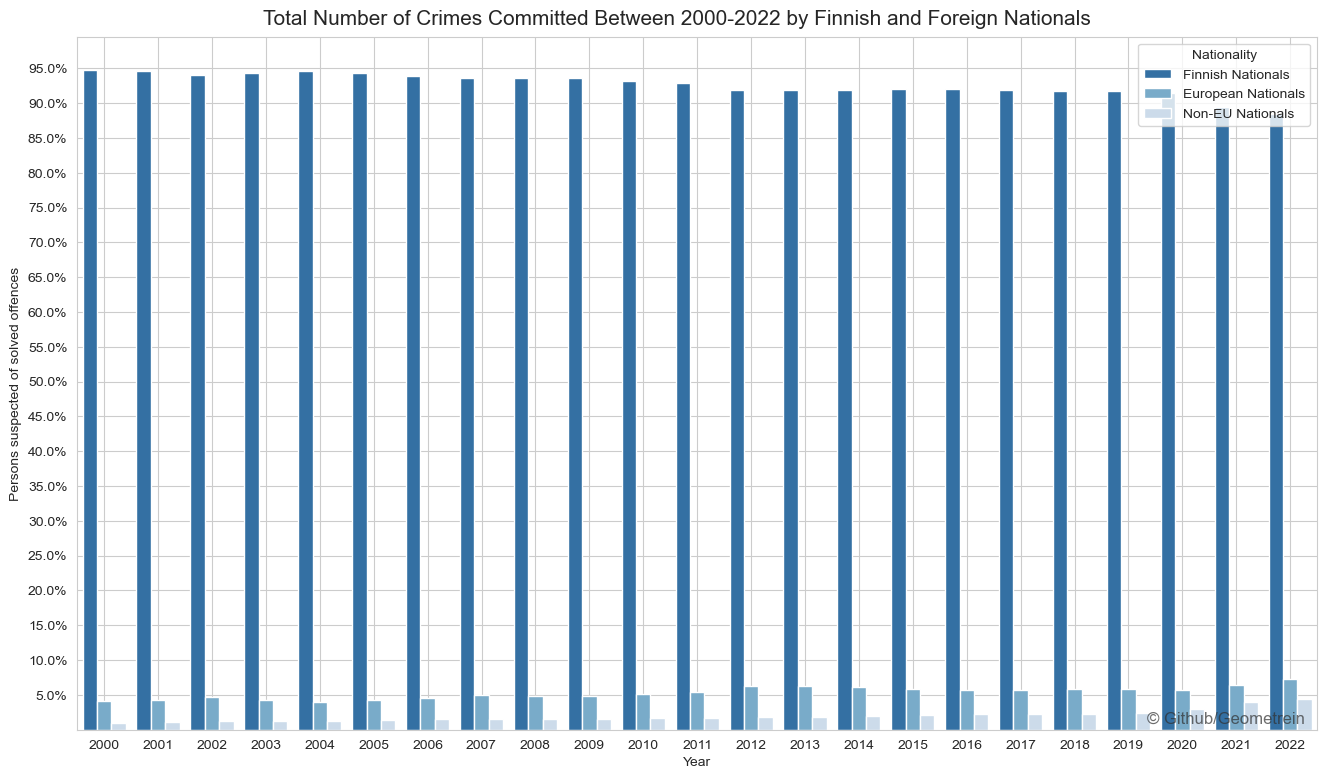

In [272]:
def plot_crime_rates_by_nationality(crimes_df: pd.DataFrame) -> None:
    # Data
    grouped_crimes = crimes_df[['Year', 'Nationality', 'Persons suspected of solved offences']].copy(deep=True)
    # Sum Non-Eu Nationals
    foreign_national = ['AMERICA', 'ASIA', 'AFRICA', 'OCEANIA']
    for year in list(grouped_crimes['Year'].unique()):
        year_df = grouped_crimes.loc[grouped_crimes['Year']==year]
        sum_value = year_df.loc[year_df['Nationality'].isin(foreign_national), 'Persons suspected of solved offences'].sum()
        row = {'Year': year, 'Nationality': 'Non-EU Nationals', 'Persons suspected of solved offences': sum_value}
        grouped_crimes = pd.concat([grouped_crimes, pd.DataFrame([row])], ignore_index=True)
    # Rename & Normalize
    mapper = {'Finland': 'Finnish Nationals', 'EUROPE': 'European Nationals', 'Non-EU Nationals': 'Non-EU Nationals'}
    grouped_crimes['Nationality'] = grouped_crimes['Nationality'].map(mapper)
    grouped_crimes = grouped_crimes.loc[grouped_crimes['Nationality'].isin(['Finnish Nationals', 'Non-EU Nationals', 'European Nationals'])]
    grouped_crimes['normalized_values'] = grouped_crimes.groupby(['Year'])['Persons suspected of solved offences'].transform(lambda x: (x * 100 / x.sum()))
    # Figure
    fig, ax = plt.subplots(figsize=(16, 9), facecolor='w')
    sns.barplot(data=grouped_crimes, x="Year", y="normalized_values", hue='Nationality', palette='Blues_r', ax=ax, errorbar=None)
    # Labels
    plt.suptitle(f"Total Number of Crimes Committed Between 2000-2022 by Finnish and Foreign Nationals", y=0.91, fontsize=15)
    ax.set(xlabel='Year', ylabel=f'Persons suspected of solved offences')
    ax.set_yticks(range(5, 100, 5))
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(decimals=1))
    ax.grid(axis='x')
    # Author
    ax.text(x=0.99, y=0.005, s='© Github/Geometrein', va='bottom', ha='right',
        transform=ax.transAxes, color='#303030', fontsize=12, alpha=0.7
    )
    plt.show()

plot_crime_rates_by_nationality(crimes_df=crimes_df)

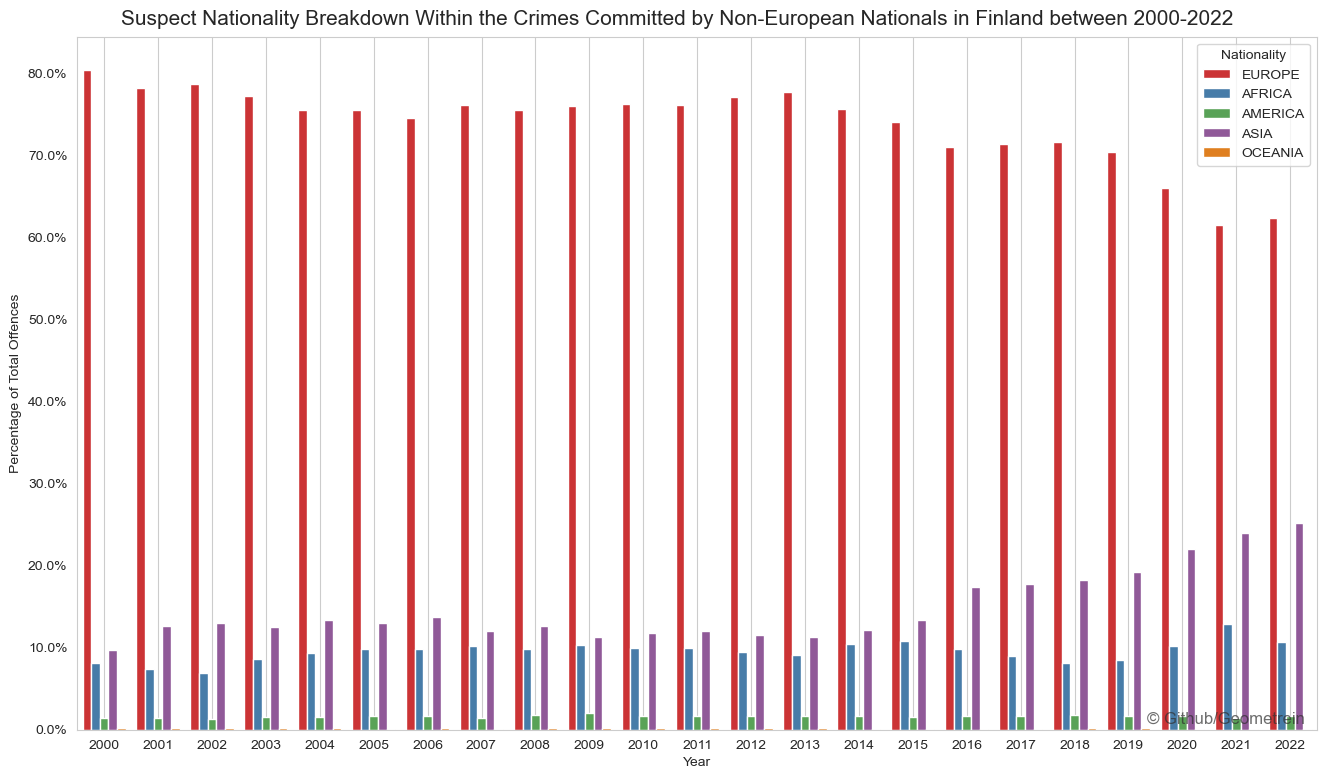

In [273]:
def plot_foreign_nationals_breakdown(crimes_df: pd.DataFrame) -> None:
    # Data
    grouped_crimes = crimes_df.copy(deep=True)
    grouped_crimes = grouped_crimes.loc[~grouped_crimes['Nationality'].isin(['FOREIGN COUNTRIES, TOTAL', 'Finland'])]
    grouped_crimes['normalized_values'] = grouped_crimes.groupby(['Year'])['Persons suspected of solved offences'].transform(lambda x: (x * 100 / x.sum()))
    # Figure
    fig, ax = plt.subplots(figsize=(16, 9), facecolor='w')
    sns.barplot(data=grouped_crimes, x="Year", y="normalized_values", hue='Nationality', palette='Set1', ax=ax, errorbar=None)
    # Labels
    plt.suptitle(f"Suspect Nationality Breakdown Within the Crimes Committed by Non-European Nationals in Finland between 2000-2022", y=0.91, fontsize=15)
    ax.set(xlabel='Year', ylabel=f'Percentage of Total Offences')
    ax.grid(axis='both')
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(decimals=1))
    # Author
    ax.text(x=0.99, y=0.005, s='© Github/Geometrein', va='bottom', ha='right',
        transform=ax.transAxes, color='#303030', fontsize=12, alpha=0.7
    )
    plt.show()

plot_foreign_nationals_breakdown(crimes_df=crimes_df)